# DL Final Project

In [1]:
from models.transunet import TransUnet
from data_processing.data_parser import DataReader
from experiments.config import get_transunet
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
X = np.load("./sampleData/trainInputsSample224.npy")
y = np.load("./sampleData/trainOutputsSample224.npy")
# X_train = X[np.newaxis, :int(len(X)*.7), :, :, :].astype("float32")
# y_train = y[np.newaxis, :int(len(y)*.7), :, :, :].astype("float32")
# X_val = X[np.newaxis, int(len(X)*.7):, :, :, :].astype("float32")
# y_val = y[np.newaxis, int(len(y)*.7):, :, :, :].astype("float32")
X_train = X[:int(len(X)*.7), :, :, :].astype("float32")
y_train = y[:int(len(y)*.7), :, :, :].astype("float32")
X_val = X[int(len(X)*.7):, :, :, :].astype("float32")
y_val = y[int(len(y)*.7):, :, :, :].astype("float32")
X_test = np.load("./sampleData/testInputsSample224.npy")
y_test = np.load("./sampleData/testOutputsSample224.npy")

In [3]:
## Train Model
config = get_transunet()
# config.image_size = 512
# config.decoder_channels = [512, 256, 128, 64]
# config.n_skip = 6
config.image_size = 224
config.filters = 3
print(config.image_size)
transunet = TransUnet(config)
transunet.compile()
#history = transunet.train_validate(training_dataset, validation_dataset, save_path, epochs=150)

224


In [4]:
history = transunet.model.fit(x=X_train.astype("float32"), y=y_train.astype("float32"), validation_data=(X_val.astype("float32"), y_val.astype("float32")), epochs=5, batch_size=20, verbose=1)

Epoch 1/5
1/1 [==============================] - 120s 120s/step - loss: 116.5021 - val_loss: 694.9924
Epoch 2/5
1/1 [==============================] - 48s 48s/step - loss: 116.7663 - val_loss: 2770417.2500
Epoch 3/5
1/1 [==============================] - 44s 44s/step - loss: 129.1012 - val_loss: 63227.1367
Epoch 4/5
1/1 [==============================] - 45s 45s/step - loss: 152.6730 - val_loss: 1293473.7500
Epoch 5/5
1/1 [==============================] - 42s 42s/step - loss: 235.2835 - val_loss: 5900813.5000


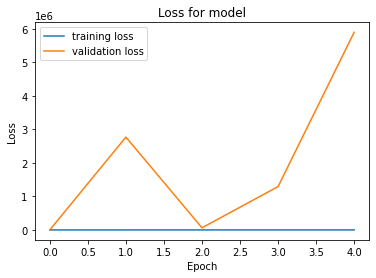

In [5]:
plt.figure()
plt.plot(history.history["loss"], label="training loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.title(f"Loss for model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [10]:
from scipy.spatial import distance

# Compute dice coefficient
def diceCoef(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    return distance.dice(y_true, y_pred)

y_preds = transunet.model.predict(X_test)

total = 0
for i in list(range(len(y_preds))):
    total = total + diceCoef(y_test[i], y_preds[i])
print("Average Dice Coefficient: ", total/len(y_preds))


Average Dice Coefficient:  -230.84164570556348


# Compute integrated gradients

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from IPython.display import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import xception

# Size of the input image
img_size = (224, 224, 3)

def get_img_array(img_path, size=(224, 224)):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def get_gradients(img_input, top_pred_idx):
    """Computes the gradients of outputs w.r.t input image.

    Args:
        img_input: 4D image tensor
        top_pred_idx: Predicted label for the input image

    Returns:
        Gradients of the predictions w.r.t img_input
    """
    images = tf.cast(img_input, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = transunet.model(images)
        top_class = preds[:, top_pred_idx]

    grads = tape.gradient(top_class, images)
    return grads


def get_integrated_gradients(img_input, top_pred_idx, baseline=None, num_steps=50):
    """Computes Integrated Gradients for a predicted label.

    Args:
        img_input (ndarray): Original image
        top_pred_idx: Predicted label for the input image
        baseline (ndarray): The baseline image to start with for interpolation
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.

    Returns:
        Integrated gradients w.r.t input image
    """
    # If baseline is not provided, start with a black image
    # having same size as the input image.
    if baseline is None:
        baseline = np.zeros(img_size).astype(np.float32)
    else:
        baseline = baseline.astype(np.float32)

    # 1. Do interpolation.
    img_input = img_input.astype(np.float32)
    interpolated_image = [
        baseline + (step / num_steps) * (img_input - baseline)
        for step in range(num_steps + 1)
    ]
    interpolated_image = np.array(interpolated_image).astype(np.float32)

    # 2. Preprocess the interpolated images
    interpolated_image = xception.preprocess_input(interpolated_image)

    # 3. Get the gradients
    grads = []
    for i, img in enumerate(interpolated_image):
        img = tf.expand_dims(img, axis=0)
        grad = get_gradients(img, top_pred_idx=top_pred_idx)
        grads.append(grad[0])
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # 4. Approximate the integral using the trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)

    # 5. Calculate integrated gradients and return
    integrated_grads = (img_input - baseline) * avg_grads
    return integrated_grads


def random_baseline_integrated_gradients(
    img_input, top_pred_idx, num_steps=50, num_runs=2
):
    """Generates a number of random baseline images.

    Args:
        img_input (ndarray): 3D image
        top_pred_idx: Predicted label for the input image
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.
        num_runs: number of baseline images to generate

    Returns:
        Averaged integrated gradients for `num_runs` baseline images
    """
    # 1. List to keep track of Integrated Gradients (IG) for all the images
    integrated_grads = []

    # 2. Get the integrated gradients for all the baselines
    for run in range(num_runs):
        baseline = np.random.random(img_size) * 255
        igrads = get_integrated_gradients(
            img_input=img_input,
            top_pred_idx=top_pred_idx,
            baseline=baseline,
            num_steps=num_steps,
        )
        integrated_grads.append(igrads)

    # 3. Return the average integrated gradients for the image
    integrated_grads = tf.convert_to_tensor(integrated_grads)
    return tf.reduce_mean(integrated_grads, axis=0)

In [18]:
class GradVisualizer:
    """Plot gradients of the outputs w.r.t an input image."""

    def __init__(self, positive_channel=None, negative_channel=None):
        if positive_channel is None:
            self.positive_channel = [0, 255, 0]
        else:
            self.positive_channel = positive_channel

        if negative_channel is None:
            self.negative_channel = [255, 0, 0]
        else:
            self.negative_channel = negative_channel

    def apply_polarity(self, attributions, polarity):
        if polarity == "positive":
            return np.clip(attributions, 0, 1)
        else:
            return np.clip(attributions, -1, 0)

    def apply_linear_transformation(
        self,
        attributions,
        clip_above_percentile=99.9,
        clip_below_percentile=70.0,
        lower_end=0.2,
    ):
        # 1. Get the thresholds
        m = self.get_thresholded_attributions(
            attributions, percentage=100 - clip_above_percentile
        )
        e = self.get_thresholded_attributions(
            attributions, percentage=100 - clip_below_percentile
        )

        # 2. Transform the attributions by a linear function f(x) = a*x + b such that
        # f(m) = 1.0 and f(e) = lower_end
        transformed_attributions = (1 - lower_end) * (np.abs(attributions) - e) / (
            m - e
        ) + lower_end

        # 3. Make sure that the sign of transformed attributions is the same as original attributions
        transformed_attributions *= np.sign(attributions)

        # 4. Only keep values that are bigger than the lower_end
        transformed_attributions *= transformed_attributions >= lower_end

        # 5. Clip values and return
        transformed_attributions = np.clip(transformed_attributions, 0.0, 1.0)
        return transformed_attributions

    def get_thresholded_attributions(self, attributions, percentage):
        if percentage == 100.0:
            return np.min(attributions)

        # 1. Flatten the attributions
        flatten_attr = attributions.flatten()

        # 2. Get the sum of the attributions
        total = np.sum(flatten_attr)

        # 3. Sort the attributions from largest to smallest.
        sorted_attributions = np.sort(np.abs(flatten_attr))[::-1]

        # 4. Calculate the percentage of the total sum that each attribution
        # and the values about it contribute.
        cum_sum = 100.0 * np.cumsum(sorted_attributions) / total

        # 5. Threshold the attributions by the percentage
        indices_to_consider = np.where(cum_sum >= percentage)[0][0]

        # 6. Select the desired attributions and return
        attributions = sorted_attributions[indices_to_consider]
        return attributions

    def binarize(self, attributions, threshold=0.001):
        return attributions > threshold

    def morphological_cleanup_fn(self, attributions, structure=np.ones((4, 4))):
        closed = ndimage.grey_closing(attributions, structure=structure)
        opened = ndimage.grey_opening(closed, structure=structure)
        return opened

    def draw_outlines(
        self, attributions, percentage=90, connected_component_structure=np.ones((3, 3))
    ):
        # 1. Binarize the attributions.
        attributions = self.binarize(attributions)

        # 2. Fill the gaps
        attributions = ndimage.binary_fill_holes(attributions)

        # 3. Compute connected components
        connected_components, num_comp = ndimage.measurements.label(
            attributions, structure=connected_component_structure
        )

        # 4. Sum up the attributions for each component
        total = np.sum(attributions[connected_components > 0])
        component_sums = []
        for comp in range(1, num_comp + 1):
            mask = connected_components == comp
            component_sum = np.sum(attributions[mask])
            component_sums.append((component_sum, mask))

        # 5. Compute the percentage of top components to keep
        sorted_sums_and_masks = sorted(component_sums, key=lambda x: x[0], reverse=True)
        sorted_sums = list(zip(*sorted_sums_and_masks))[0]
        cumulative_sorted_sums = np.cumsum(sorted_sums)
        cutoff_threshold = percentage * total / 100
        cutoff_idx = np.where(cumulative_sorted_sums >= cutoff_threshold)[0][0]
        if cutoff_idx > 2:
            cutoff_idx = 2

        # 6. Set the values for the kept components
        border_mask = np.zeros_like(attributions)
        for i in range(cutoff_idx + 1):
            border_mask[sorted_sums_and_masks[i][1]] = 1

        # 7. Make the mask hollow and show only the border
        eroded_mask = ndimage.binary_erosion(border_mask, iterations=1)
        border_mask[eroded_mask] = 0

        # 8. Return the outlined mask
        return border_mask

    def process_grads(
        self,
        image,
        attributions,
        polarity="positive",
        clip_above_percentile=99.9,
        clip_below_percentile=0,
        morphological_cleanup=False,
        structure=np.ones((3, 3)),
        outlines=False,
        outlines_component_percentage=90,
        overlay=True,
    ):
        if polarity not in ["positive", "negative"]:
            raise ValueError(
                f""" Allowed polarity values: 'positive' or 'negative'
                                    but provided {polarity}"""
            )
        if clip_above_percentile < 0 or clip_above_percentile > 100:
            raise ValueError("clip_above_percentile must be in [0, 100]")

        if clip_below_percentile < 0 or clip_below_percentile > 100:
            raise ValueError("clip_below_percentile must be in [0, 100]")

        # 1. Apply polarity
        if polarity == "positive":
            attributions = self.apply_polarity(attributions, polarity=polarity)
            channel = self.positive_channel
        else:
            attributions = self.apply_polarity(attributions, polarity=polarity)
            attributions = np.abs(attributions)
            channel = self.negative_channel

        # 2. Take average over the channels
        attributions = np.average(attributions, axis=2)

        # 3. Apply linear transformation to the attributions
        attributions = self.apply_linear_transformation(
            attributions,
            clip_above_percentile=clip_above_percentile,
            clip_below_percentile=clip_below_percentile,
            lower_end=0.0,
        )

        # 4. Cleanup
        if morphological_cleanup:
            attributions = self.morphological_cleanup_fn(
                attributions, structure=structure
            )
        # 5. Draw the outlines
        if outlines:
            attributions = self.draw_outlines(
                attributions, percentage=outlines_component_percentage
            )

        # 6. Expand the channel axis and convert to RGB
        attributions = np.expand_dims(attributions, 2) * channel

        # 7.Superimpose on the original image
        if overlay:
            attributions = np.clip((attributions * 0.8 + image), 0, 255)
        return attributions

    def visualize(
        self,
        image,
        gradients,
        integrated_gradients,
        polarity="positive",
        clip_above_percentile=99.9,
        clip_below_percentile=0,
        morphological_cleanup=False,
        structure=np.ones((3, 3)),
        outlines=False,
        outlines_component_percentage=90,
        overlay=True,
        figsize=(15, 8),
    ):
        # 1. Make two copies of the original image
        img1 = np.copy(image)
        img2 = np.copy(image)

        # 2. Process the normal gradients
        grads_attr = self.process_grads(
            image=img1,
            attributions=gradients,
            polarity=polarity,
            clip_above_percentile=clip_above_percentile,
            clip_below_percentile=clip_below_percentile,
            morphological_cleanup=morphological_cleanup,
            structure=structure,
            outlines=outlines,
            outlines_component_percentage=outlines_component_percentage,
            overlay=overlay,
        )

        # 3. Process the integrated gradients
        igrads_attr = self.process_grads(
            image=img2,
            attributions=integrated_gradients,
            polarity=polarity,
            clip_above_percentile=clip_above_percentile,
            clip_below_percentile=clip_below_percentile,
            morphological_cleanup=morphological_cleanup,
            structure=structure,
            outlines=outlines,
            outlines_component_percentage=outlines_component_percentage,
            overlay=overlay,
        )

        _, ax = plt.subplots(1, 3, figsize=figsize)
        ax[0].imshow(image)
        ax[1].imshow(grads_attr.astype(np.uint8))
        ax[2].imshow(igrads_attr.astype(np.uint8))

        ax[0].set_title("Input")
        ax[1].set_title("Normal gradients")
        ax[2].set_title("Integrated gradients")
        plt.show()

Predicted: [[[[12594.902  12320.077  12309.673 ]
   [21975.59   21499.08   21468.25  ]
   [29372.074  28734.084  28688.719 ]
   ...
   [22867.506  22374.887  22334.125 ]
   [16894.662  16532.326  16502.123 ]
   [ 9296.269   9100.793   9082.065 ]]

  [[22227.365  21755.62   21741.441 ]
   [39050.84   38246.434  38210.656 ]
   [52318.062  51246.234  51196.47  ]
   ...
   [40807.79   39992.195  39951.066 ]
   [30084.344  29488.236  29457.912 ]
   [16464.855  16152.784  16134.214 ]]

  [[29345.547  28728.836  28710.543 ]
   [51701.9    50654.79   50611.74  ]
   [69351.9    67958.39   67900.08  ]
   ...
   [54329.62   53268.68   53222.44  ]
   [40037.766  39263.246  39229.188 ]
   [21885.617  21483.566  21462.516 ]]

  ...

  [[22880.195  22415.352  22404.992 ]
   [40360.91   39583.496  39562.67  ]
   [54337.133  53303.266  53278.496 ]
   ...
   [46959.297  46101.11   46086.832 ]
   [34745.867  34120.27   34110.375 ]
   [19068.58   18750.115  18745.27  ]]

  [[16968.518  16627.18   16620.95

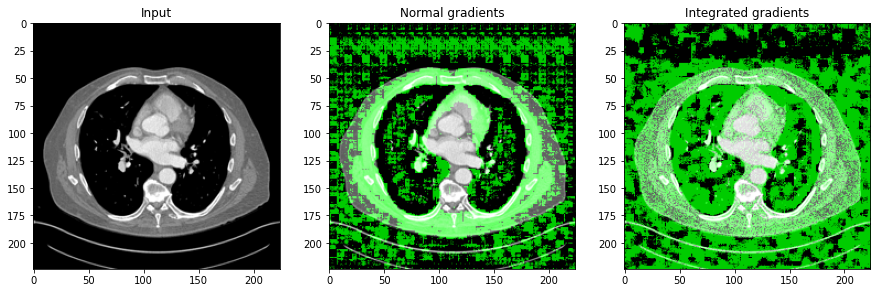

In [21]:
############                                                                           ############
############ Index 6 was randomly chosen to use as an example for integrated gradients ############
############                                                                           ############

img =  array = np.expand_dims(y_test[6], axis=0)
orig_img = np.copy(img[0]).astype(np.uint8)

img_processed = tf.cast(xception.preprocess_input(img), dtype=tf.float32)

# 4. Get model predictions
preds = transunet.model.predict(img_processed)
#top_pred_idx = tf.argmax(preds[0])
print("Predicted:", preds)#top_pred_idx, xception.decode_predictions(preds, top=1)[0])

# 5. Get the gradients of the last layer for the predicted label
grads = get_gradients(img_processed, top_pred_idx=0)

# 6. Get the integrated gradients
igrads = random_baseline_integrated_gradients(
    np.copy(orig_img), top_pred_idx=0, num_steps=50, num_runs=2
)

# 7. Process the gradients and plot
vis = GradVisualizer()
vis.visualize(
    image=orig_img,
    gradients=grads[0].numpy(),
    integrated_gradients=igrads.numpy(),
    clip_above_percentile=99,
    clip_below_percentile=0,
)

# Code below uses train_validate(). Doe same thing as code above, but also computes dice coefficient automatically. Was not able to get it to work

In [73]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).repeat(10)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).repeat(10)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).repeat(10)

In [76]:
transunet.train_validate(training_dataset=train_dataset, validation_dataset=val_dataset, save_path="./", validation_samples=5, epochs=1, batch_size=100, show_history=True)

10/22 [============>.................] - ETA: 6:21 - loss: 4475686.5000

KeyboardInterrupt: 

In [9]:
print(type(y_preds))
print(y_preds.shape)

<class 'numpy.ndarray'>
(15, 224, 224, 3)
